<a href="https://colab.research.google.com/github/jvictorferreira3301/LaTeX_OCR_IC/blob/main/latexOCR.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" style="height: 27px; margin-right: 10px;"/>

## LATex OCR 📝

### 1. Introduction

LaTeX-OCR is an advanced application that combines OCR and Transformers technologies to automate the conversion of mathematical expressions into LaTeX code, bringing efficiency to academic and scientific activities. Although it still faces challenges with complex data and manuscripts, it represents an important evolution in the use of AI to facilitate the digitization and editing of complex mathematical content.

<div style="display: flex; justify-content: center;">
    <figure style="margin-right: 10px; text-align: center;">
        <img src="./assets/wf.png" width="auto" height="auto" style="display: flex; margin:0">
        <figcaption>Fig. 1 - Flowchart of application. </figcaption>
    </figure>
    <figure style="text-align: center;">
        <img src="./assets/gif.gif" width="auto" height="auto" tyle="display: flex; margin:10px">
        <figcaption> Fig. 2 - Example of use with GUI.</figcaption>
    </figure>
</div>

#### 1.1. Background

<div style="text-align: center;">
        <img src="./assets/timeline.svg" width="auto" height="auto">
        <figcaption>Fig. 3 - Timeline of models.</figcaption>
    </figure>
</div>

- **Optical Character Recognition (OCR):** is the technology used to identify and extract text from images. In applications like LaTeX-OCR, OCR needs to go beyond simple text reading and recognize the hierarchical structure of mathematical expressions.

- **Image Tokenization:** Tokenization is the process of breaking data into smaller units, called tokens, that can be processed individually. In traditional text OCR, each character or word may be a token; in images of equations, each part of the expression (symbol, operator, or substructure) can be tokenized.

- **Attention and Self-Attention:** Attention is a mechanism that allows the model to “focus” on specific parts of the data when making decisions. Self-attention enables each part of the sequence (or image) to consider all other parts, capturing complex dependencies.

- **Positional Encoding**: In neural networks, especially Transformers, positional encoding is used to preserve the order of tokens, as the model itself does not maintain an explicit sequence.

- **Transformers and Encoder-Decoder Networks:** Transformers are neural networks that use attention mechanisms to process data sequences. Encoder-Decoder models are a common Transformer architecture for translating input sequences to output sequences.

Given the foundation, we will train the model using our dataset extracted from the LaTeX files of the following books by Prof. Aldebaro Klautau.

- _Digital Signal Processing with Python, Matlab or Octave_
- _Digital Communications with Python, Matlab or Octave_


### 2. Data extraction

#### 2.1. Extract equations

Extract all equations from .tex files to a single .tex 

In [ ]:
# 70% ChatGPT :D

import re
from pathlib import Path
from wand.image import Image
from wand.color import Color
import os
import subprocess
from concurrent.futures import ThreadPoolExecutor

def load_macros(macros_file):
    """Reads macros from a LaTeX macros file and returns a dictionary of replacements."""
    macros = {}
    macro_pattern = r'\\(?:def|newcommand)\s*\\(\w+)\s*(?:\[(.*?)\])?\s*(\{(.*)\})'
    
    with open(macros_file, 'r') as file:
        for line in file:
            match = re.match(macro_pattern, line.strip())
            if match:
                command, _, definition, inside_def = match.groups()

                macros[rf'\\{command}'] = inside_def  # Store macro with regex-escaped backslash

                # print(f'{command} {inside_def}')
            
    return macros

def replacement_function(match, definition, param_mapping):
    if len(param_mapping) > 0:
        print(f'{match} {definition} {param_mapping}')

def replace_macros(equations, macros):
    """Replaces macros in equations using the given macros dictionary, ensuring standalone replacements."""
    for i, equation in enumerate(equations):
        for macro, definition in macros.items():
            # Replace each macro with its definition
            # This regex captures the argument inside the curly braces
            equation = re.sub(
                rf'(?<!\\)({macro})\{{(.*?)\}}',  # Match macro and its argument
                lambda match: definition.replace('#1', match.group(2).replace('$', '')),  # Replace #1 with the captured argument
                equation
            )
          

        equations[i] = equation
    return equations

def replace_macros2(equations, macros):
    """Replaces macros in equations using the given macros dictionary, ensuring standalone replacements."""
    for i, equation in enumerate(equations):
        for macro, definition in macros.items():
            # Check if the definition contains placeholders
            param_pattern = re.findall(r'#(\d+)', definition)

            # Create a mapping for parameters if there are placeholders
            param_mapping = {}
            for j in range(len(param_pattern)):
                param_index = int(param_pattern[j]) - 1  # Convert to 0-based index
                # Capture parameters from the equation based on their positions
                matches = re.findall(r'(\{.*?\}|\S+)', equation)  # Capture everything in braces and standalone words
                if param_index < len(matches):
                    param_mapping[f'#{j + 1}'] = matches[param_index]

            # Replace each macro using a lambda to avoid escape sequence issues
            equation = re.sub(
                rf'(?<!\\)({macro})(?![a-zA-Z0-9])',
                lambda match: re.sub(
                    r'(#\d+)',
                    lambda m: param_mapping.get(m.group(0), m.group(0)),  # Substitute placeholders with mapped values
                    definition
                ),
                equation
            )
        equations[i] = equation
    return equations

def extract_equations(input_tex_file, macros_file):
    # Load macros from macros_file
    macros = load_macros(macros_file)
    
    # Regular expressions to match equations
    equation_patterns = [
        # r'\$\$(.*?)\$\$',            # Inline equations with $$ ... $$
        # r'\$(.*?)\$',                # Inline equations with $ ... $
        r'\\\[(.*?)\\\]',            # Displayed equations with \[ ... \]
        r'\\begin\{equation\}(.*?)\\end\{equation\}',  # equation environment
        # r'\\begin\{align\}(.*?)\\end\{align\}'         # align environment
    ]
    
    # Read the input LaTeX file
    with open(input_tex_file, 'r') as file:
        tex_content = file.read()
    
    # Find all matches for each pattern
    equations = []
    for pattern in equation_patterns:
        matches = re.findall(pattern, tex_content, re.DOTALL)
        equations.extend(matches)
    
    # Replace macros in equations
    equations = replace_macros(equations, macros)
    equations = replace_macros2(equations, macros)

    return equations
    
tex_files_folder = 'bootor_tex'

output_tex_file = f'outputs/extracted_equations.tex'

macros_file = 'macros/macros.tex'

total_equations = 0

if not os.path.exists('outputs'):
        os.mkdir('outputs')

# Write equations to a new .tex file
with open(output_tex_file, 'w') as output_file:
    output_file.write('\\documentclass{article}\n')
    output_file.write('\\usepackage{amsmath}\n')
    output_file.write('\\usepackage{amssymb}\n')
    output_file.write('\\begin{document}\n')

    for subfolder in Path(tex_files_folder).glob('*'):

        for file in subfolder.glob('*'):
            equations = extract_equations(file, macros_file)

            # Write each extracted equation
            for eq in equations:
                output_file.write('\n\\begin{equation}\n')
                output_file.write(eq.strip())
                output_file.write('\n\\end{equation}\n')

            print(f"Extracted {len(equations)} equations from {file}.")
            total_equations = total_equations + len(equations)

    # Write end of the document
    output_file.write('\\end{document}\n')

print(f'Found {total_equations} equations in the folder {tex_files_folder}')

#### 2.2. Equations to .txt

Parse extracted equations to a .txt where each line will be a different equation

In [ ]:
def extract_equations(input_file, output_file):
    # Regular expression for LaTeX equations in \begin{equation} ... \end{equation}, ignoring \label{}
    equation_pattern = r'\\begin\{equation\}(.+?)\\end\{equation\}'
    label_pattern = r'\\label\{[^}]*\}'  # Pattern to match and remove labels

    # Read input file and extract equations
    with open(input_file, 'r') as file:
        content = file.read()

        # Find all matches for the equation pattern
        equations = re.findall(equation_pattern, content, re.DOTALL)
        
        # Process each equation to remove labels and convert to a single line
        cleaned_equations = []
        for eq in equations:
            cleaned_eq = re.sub(label_pattern, '', eq)  # Remove label

            eq_lines = cleaned_eq.split('\n')

            poped = 0
            for i in range(len(eq_lines)):                
                if eq_lines[i - poped].replace(' ', '').startswith('%'):
                    eq_lines.pop(i - poped)
                    poped += 1

                if (len(eq_lines[i - poped].split('%')) > 1):
                    eq_lines[i - poped] = eq_lines[i - poped].split('%')[0]

            cleaned_eq = ''.join(eq_lines)

            cleaned_eq = re.sub(r'\s+', ' ', cleaned_eq)  # Replace multiple spaces/newlines with a single space
            cleaned_eq = cleaned_eq.strip()  # Trim leading and trailing spaces
            cleaned_equations.append(cleaned_eq)

    # Write each cleaned equation to a new line in the output file
    with open(output_file, 'w') as file:
        total_equations = 0
        for equation in cleaned_equations:
            if len(equation) > 0:
                file.write(equation + '\n')
                total_equations += 1

        print(f'Extracted {total_equations} usable equations!')

# Usage
input_tex_file = 'outputs/extracted_equations.tex'
output_txt_file = 'outputs/extracted_equations.txt'
extract_equations(input_tex_file, output_txt_file)


#### 2.3. Generate PDFs



Compile extracted equations to PDF (each equation generates a different file)

In [3]:
def extract_equations(input_txt_file):
    """Extract equations from the input .txt file, each line being an equation."""
    equations = []
    with open(input_txt_file, 'r') as file:
        # Read each line and strip any extra whitespace
        for line in file:
            stripped_line = line.strip()
            if stripped_line:  # Only add non-empty lines
                equations.append(stripped_line)
    return equations

def create_tex_file(equation, index):
    """Create a .tex file for the given equation."""
    tex_content = r"""\documentclass{article}
\usepackage{amsmath}
\usepackage{amssymb}
\usepackage{xcolor}
\begin{document}
\pagestyle{empty}
\begin{equation*}
""" + equation + r"""
\end{equation*}
\end{document}
"""
    file_name = f"{str(index).zfill(5)}.tex"
    with open(file_name, 'w') as file:
        file.write(tex_content)
    return file_name

def compile_tex_file(tex_file):
    """Compile the .tex file using XeLaTeX."""
    subprocess.run(['xelatex', tex_file], check=True)

def compile_tex_files(tex_files):
    """Compile multiple .tex files concurrently."""
    with ThreadPoolExecutor(max_workers=10) as executor:
        executor.map(compile_tex_file, tex_files)

def main(input_tex_file):
    if not os.path.exists('outputs/pdfs'):
        os.makedirs('outputs/pdfs')

    equations = extract_equations(input_tex_file)

    tex_files = []
    for index, equation in enumerate(equations):
        tex_file = create_tex_file(equation.strip(), index)
        tex_files.append(tex_file)

    # Compile all .tex files concurrently
    compile_tex_files(tex_files)

    # Move PDFs to the output directory and clean up auxiliary files
    for tex_file in tex_files:
        pdf_file = Path(tex_file).with_suffix('.pdf')
        if pdf_file.exists():
            pdf_file.rename(Path('outputs/pdfs') / pdf_file.name)
            # Clean up auxiliary files
            os.remove(tex_file)
            os.remove(tex_file.replace('.tex', '.aux'))
            os.remove(tex_file.replace('.tex', '.log'))

if __name__ == "__main__":
    input_tex_file = 'outputs/extracted_equations.txt'
    main(input_tex_file)

#### 2.4. PDF to PNG

Convert PDF files to PNG images

In [4]:
SRC_PATH = 'outputs/pdfs'
TRG_PATH = 'outputs/images'
RESOLUTION = 200  # lower resolution for faster processing

def convert_pdf_to_png(pdf_path):
    output_path = Path(TRG_PATH) / f"{pdf_path.stem}.png"
    with Image(filename=str(pdf_path), resolution=RESOLUTION) as img:
        img.format = 'png'
        img.trim(color=Color('rgba(0,0,0,0)'), fuzz=0)  # Trim transparent areas
        img.background_color = Color('white')  # Set white background
        img.alpha_channel = 'remove'           # Remove transparency
        img.save(filename=str(output_path))
    print(f"Converted {pdf_path} to {output_path}")

def main():
    if not os.path.exists('outputs/images'):
        os.mkdir('outputs/images')

    pdf_dir = Path(SRC_PATH)
    pdf_files = list(pdf_dir.glob('*.pdf'))

    with ThreadPoolExecutor(max_workers=10) as executor:
        executor.map(convert_pdf_to_png, pdf_files)

if __name__ == "__main__":
    main()

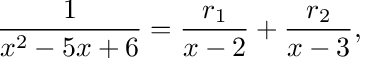

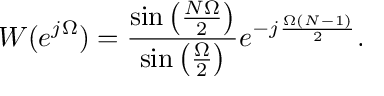

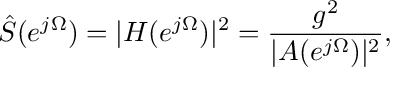

### 3. Training the model

#### 3.1 Pre-processing

##### Normalizing LaTeX

In [ ]:
# Using code from the original repo

!python LaTeX-OCR/pix2tex/dataset/preprocessing/preprocess_formulas.py -i extracted_equations.txt -o norm.txt

Extracted LaTeX:
``\hat {\cal P} = 10 \log_{10} {\cal P}\textrm{~~~~~~~(${\cal P}$ in W and $\hat {\cal P}$ in dBW)}.``

Normalized LaTeX:
``\hat { \cal P } = 1 0 \log _ { 1 0 } { \cal P } \textrm { ~ ~ ~ ~ ~ ~ ~ ( { \cal P } i n W a n d \hat { \cal P } i n d B W ) } .``


Extracted LaTeX:
``{ \cal X } [ n ] \rightarrow \boxed { M _ { x } ^ { - 1 } ( z ) } \rightarrow { \cal I } [ n ] \rightarrow \boxed { M _ { x } ( z ) } \rightarrow { \cal X } [ n ]``

Normalized LaTeX:
``{\cal X}[n] \rightarrow\boxed{M_x^{-1}(z)}\rightarrow {\cal I}[n] \rightarrow\boxed{M_x(z)}\rightarrow {\cal X}[n]``


#### Normalizing Images

Apply padding to images, width and size needs to be divisible by the patch size 

In [ ]:
import cv2
import os
from pathlib import Path
from PIL import Image
import numpy as np

# Code from original repo
def pad(img: Image, divable=32): 
    """Pad an Image to the next full divisible value of `divable`. Also normalizes the image and inverts if needed. 
    Args: 
        img (PIL.Image): input image 
        divable (int, optional): . Defaults to 32. 
    Returns: 
        PIL.Image 
    """ 
    data = np.array(img.convert('LA')) 
    data = (data - data.min()) / (data.max() - data.min()) * 255 
    if data[..., 0].mean() > 128: 
        gray = 255 * (data[..., 0] < 128).astype(np.uint8)  # To invert the text to white 
    else: 
        gray = 255 * (data[..., 0] > 128).astype(np.uint8) 
        data[..., 0] = 255 - data[..., 0] 

    coords = cv2.findNonZero(gray)  # Find all non-zero points (text) 
    a, b, w, h = cv2.boundingRect(coords)  # Find minimum spanning bounding box 
    rect = data[b:b+h, a:a+w] 
    if rect[..., -1].var() == 0: 
        im = Image.fromarray((rect[..., 0]).astype(np.uint8)).convert('L') 
    else: 
        im = Image.fromarray((255 - rect[..., -1]).astype(np.uint8)).convert('L') 
    dims = [] 
    for x in [w, h]: 
        div, mod = divmod(x, divable) 
        dims.append(divable * (div + (1 if mod > 0 else 0))) 
    padded = Image.new('L', dims, 255) 
    padded.paste(im, im.getbbox()) 
    return padded 

def convert_images(input_dir, output_dir):
    """Convert all images in the input directory to grayscale and save in the output directory."""
    # Ensure the output directory exists
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # Process each image file in the input directory
    for img_file in os.listdir(input_dir):
        img_path = os.path.join(input_dir, img_file)
        
        # Check if the file is a PNG image
        if img_path.endswith('.png'):
            # Read the image with PIL
            img = Image.open(img_path)
            pad_img = pad(img)

            # Convert the padded image back to a NumPy array for saving with OpenCV
            pad_img_np = np.array(pad_img)
            
            # Create output file path
            output_path = os.path.join(output_dir, img_file)
            
            # Save the grayscale image using OpenCV
            cv2.imwrite(output_path, pad_img_np)
            print(f"Converted and saved: {output_path}")

input_dir = 'outputs/images' 
output_dir = 'outputs/images_pad'

convert_images(input_dir, output_dir)

Example of input (41):

c _ { k } = \frac { 1 } { T _ { 0 } } \int _ { \langle T _ { 0 } \rangle } x ( t ) e ^ { - j 2 \pi k f _ { 0 } t } d t \quad , k = - \infty , \ldots , - 1 , 0 , 1 , \ldots , \infty \,

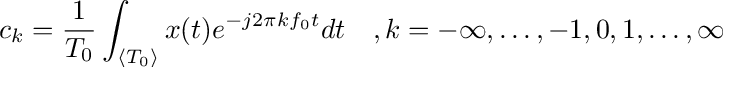

#### Configuring the model

"The model consist of a ViT [1] encoder with a ResNet backbone and a Transformer [2] decoder." 

```yaml
{
  backbone_layers: [2, 3, 7],
  betas: [0.9, 0.999],
  batchsize: 10,
  bos_token: 1,
  channels: 1,
  debug: true,
  wandb: true,
  decoder_args:
    {
      "attn_on_attn": true,
      "cross_attend": true,
      "ff_glu": true,
      "rel_pos_bias": false,
      "use_scalenorm": false,
    },
  dim: 256,
  encoder_depth: 4,
  eos_token: 2,
  epochs: 50,
  gamma: 0.9995,
  heads: 8,
  id: null,
  load_chkpt: null,
  lr: 0.001,
  lr_step: 30,
  max_height: 192,
  max_seq_len: 512,
  max_width: 672,
  min_height: 32,
  min_width: 32,
  model_path: checkpoints_bootor,
  name: bootor_40epoch,
  num_layers: 4,
  num_tokens: 8000,
  optimizer: Adam,
  output_path: outputs,
  pad: false,
  pad_token: 0,
  patch_size: 16,
  sample_freq: 2000,
  save_freq: 1,
  scheduler: StepLR,
  seed: 42,
  temperature: 0.2,
  test_samples: 5,
  testbatchsize: 20,
  valbatches: 100,
  tokenizer: data_bootor/tokenizer.json,
  valdata: data_bootor/val.pkl,
  data: data_bootor/train.pkl,
}
```

#### Generate tokenizer

```json
"vocab": {
            "[PAD]": 0,
            "[BOS]": 1,
            "[EOS]": 2,
            "!": 3,
            "&": 4,
            "(": 5,
            ")": 6,
            "*": 7,
            "+": 8,
            ",": 9,
            "-": 10,
            ".": 11,
            ....,
            "alpha": 198,
            "box": 199,
            "eta": 200,
            "ray": 201,
            "array": 202,
            "ed": 203,
            "boxed": 204,
            "Ġ8": 205,
            "lo": 206,
            "Ġo": 207,
            "ĠB": 208,
            "ĠW": 209,
            "bb": 210,
            "mathbb": 211,
            "Ġ6": 212,
            "cos": 213,
            "langle": 214,
            "rangle": 215,
            "Ġ\\\\": 216,
            "hat": 217,
            "Ġ*": 218,
            "Ġ9": 219,
            "sin": 220,
            "Ġu": 221,
            "maths": 222,
            "log": 223,
            "mathsf": 224,
            "delta": 225,
            "ert": 226,
            "Ġ7": 227,
            "nd": 228,
            "ime": 229,
            "qrt": 230,
            "sqrt": 231,
            "hi": 232,
            "Delta": 233,
            "Vert": 234,
            "ap": 235,
            "er": 236,
            "ld": 237,
            "app": 238,
            "ĠQ": 239,
            "ĠY": 240,
            "be": 241,
            "end": 242,
            "gin": 243,
            "begin": 244,
            "sig": 245,
            "Ġg": 246,
            "sigma": 247,
```

#### Training

70% Train

20% Test

10% Validation

##### Generating PKLs

In [ ]:
import os
os.makedirs(f'data_{dataset}', exist_ok=True)

dataset = 'bootor'

# Extract train data
!python -m pix2tex.dataset.dataset --equations ../datasets/{dataset}/labels.txt --images ../datasets/{dataset}/images/train --out data_{dataset}/train.pkl

# Extract validation data
!python -m pix2tex.dataset.dataset --equations ../datasets/{dataset}/labels.txt --images ../datasets/{dataset}/images/val --out data_{dataset}/val.pkl

#### Train using our data (1029 equations)

In [ ]:
# Code from original repo
!python -m pix2tex.train --config config.yaml

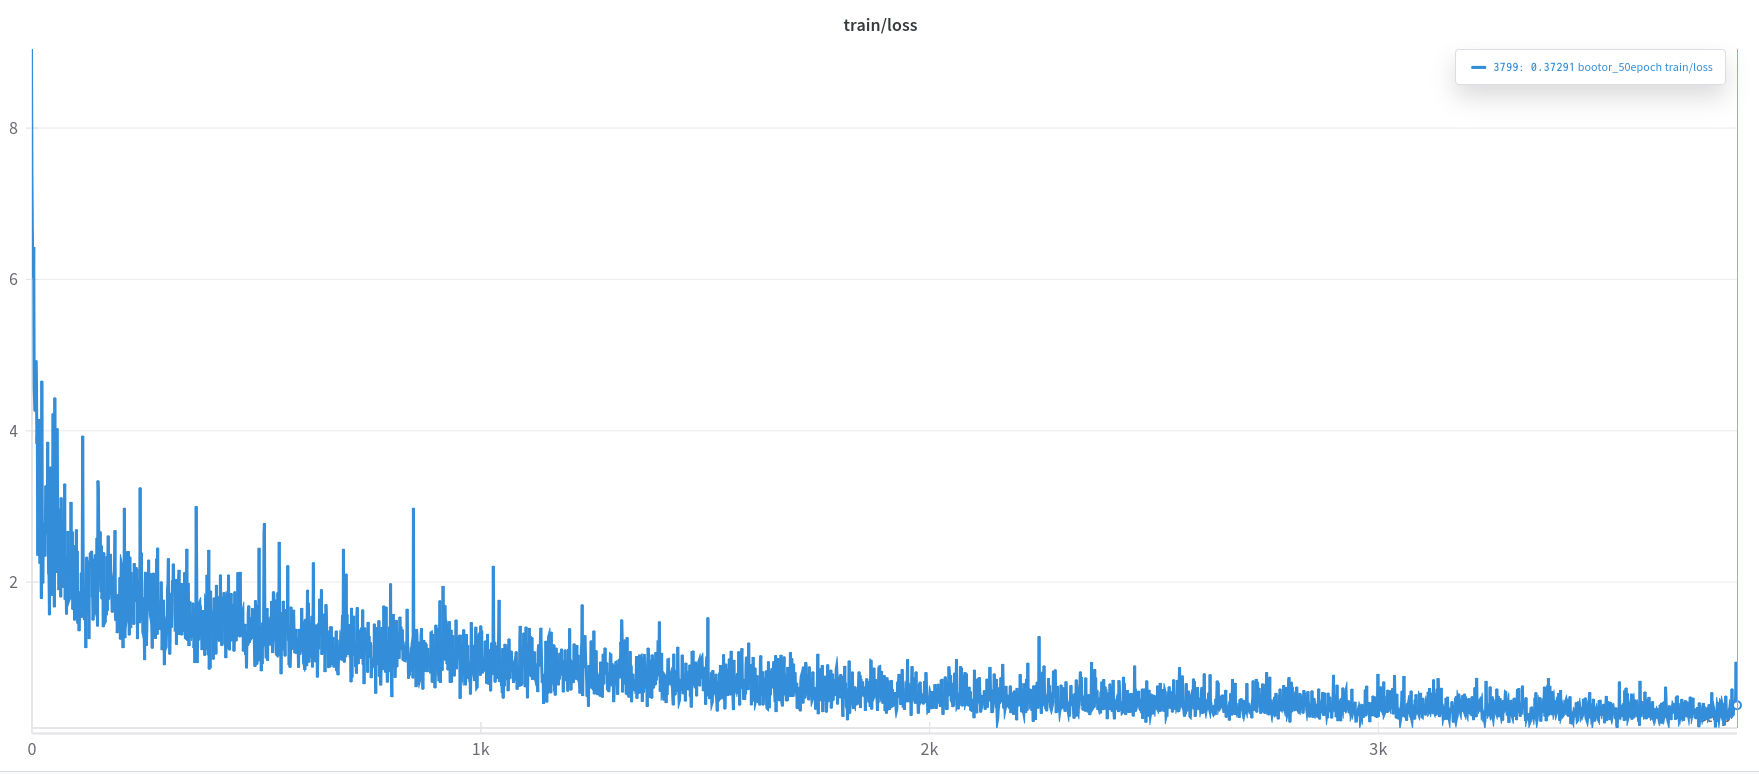

Loss function: 0.3729 at the last batch

##### Scores (validation)

- val/edit_distance	2.190018917194931 # Measures how many edits are required to transform the predicted text into the reference text.
- val/token_acc	0.04835147319716357 # Percentage of tokens in the prediction that match the tokens in the ground truth.
- val/bleu	0.0589972678833401 # BLEU (Bilingual Evaluation Understudy): Similarity between generated and reference text.

- Truth: 2b a^{n}\cos(\theta n+\alpha)u[n].
- Prediction: {\textbf A}=H{\textbf A}{\textbf A}{\textbf A}.

- Truth: ||{\textbf X}||=||{\textbf A}{\textbf x}||=||{\textbf x}||.
- Prediction: \overline{{b}}=b/N.

#### Fine tuning pre-trained model

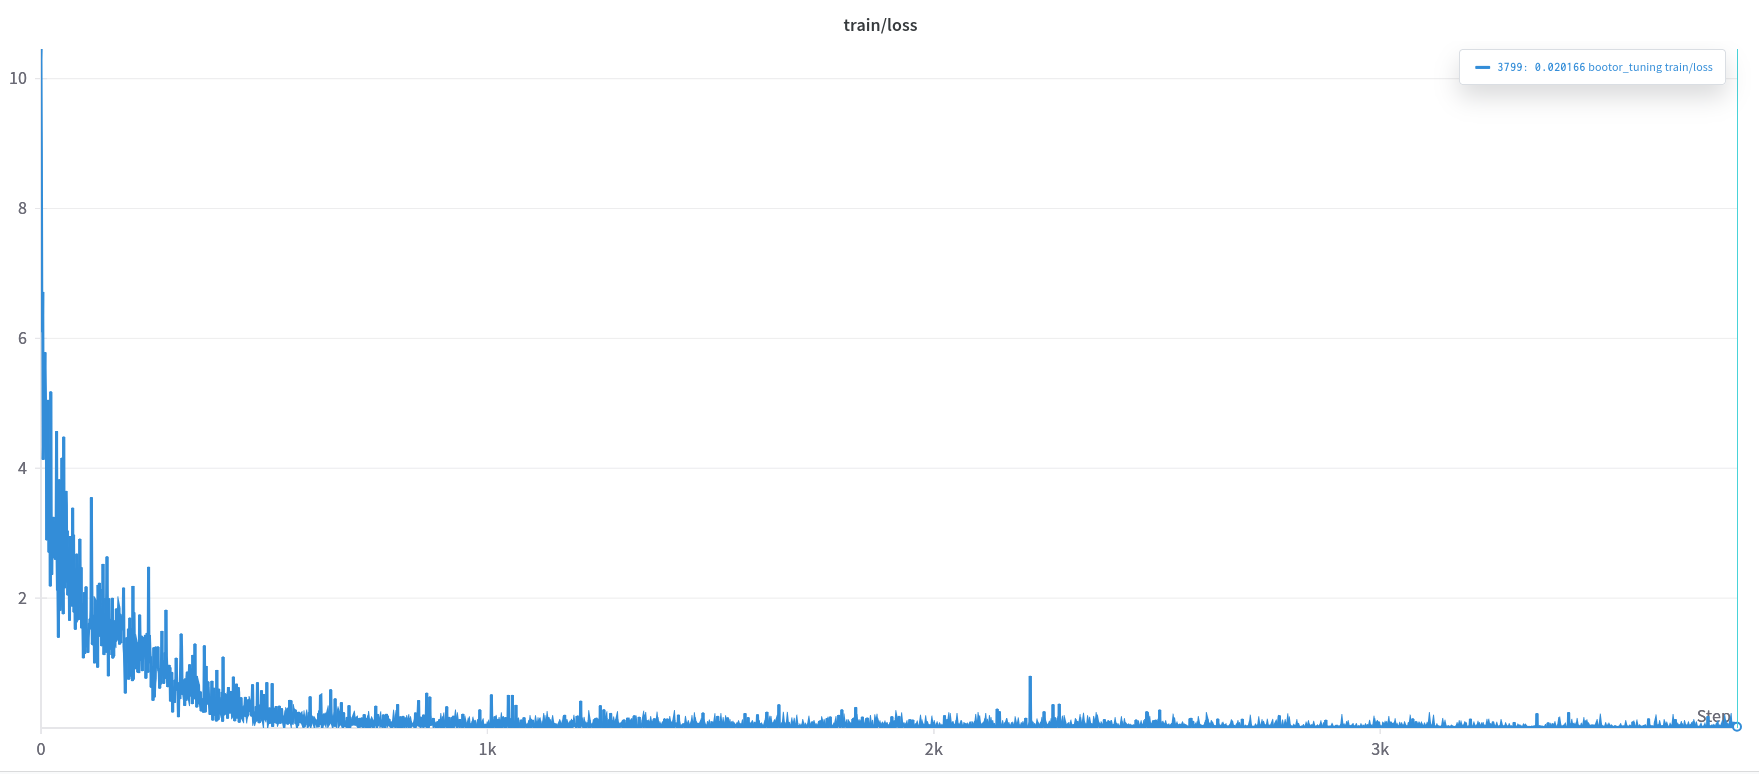

Loss function: 0.020166 at the last batch

##### Scores (validation)

- edit_distance 0.18750186692017756
- token_acc	0.5445008777037618
- val/bleu	0.7937541433238978

- Truth: 2b a^{n}\cos(\theta n+\alpha)u[n].
- Prediction: 2b a^{n}\cos(\theta n+\alpha)u[n].

- Truth: ||{\textbf X}||=||{\textbf A}{\textbf x}||=||{\textbf x}||.
- Prediction: \lVert{\textbf x}\rVert=\rVert{\textbf A}{\textbf x}\rVert=\rVert{\textbf x}\rVert.

#### 4 Perfomance with test samples

In [ ]:
# :(